In [1]:
import h5py as h5
from PreFRBLE.convenience import *
from PreFRBLE.plot import *

In [2]:
def WeighBayes( B, w ):
    w_log = np.log10(w)
    return 10.**( np.log10(B) * (1+np.abs(w_log))**(1 - 2*(w_log<0) - (w_log==0) )  ) 

In [3]:
WeighBayes( 10.**np.arange(-3,4), 0.01 )

array([ 0.1       ,  0.21544347,  0.46415888,  1.        ,  2.15443469,
        4.64158883, 10.        ])

([<matplotlib.axis.YTick at 0x7fa4c73f4400>,
 <a list of 9 Text yticklabel objects>)

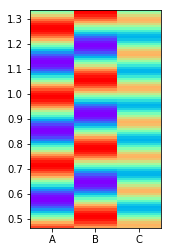

In [79]:
N=100
n=np.arange(N)/5
a=np.arange(N).repeat(3).reshape(N,3)

a = np.array([np.sin(n), np.cos(n), np.sin(n)*np.cos(n)]).transpose()

x = np.round(np.arange(0.5,1.4,0.1),1)
y = np.arange(-1,2)
y_labels = ['A','B','C']


plt.imshow( a, cmap=rainbow, extent=[0,30,0,50] )
plt.xticks( [5,15,25], y_labels )
plt.yticks( np.linspace(2,48,len(x)), x )

In [82]:
plt.imshow?
from matplotlib.colors import LogNorm
LogNorm?

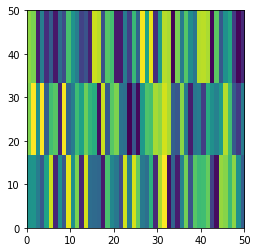

In [69]:
plt.imshow(np.random.rand(3,50), aspect='equal', extent=[0,50,0,50])

In [52]:
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck15
from scipy import integrate

z1 = 0.01

dist1 = Distance(unit=u.pc, z = z1, cosmology = Planck15)

dist1.pc


44595101.92007588

In [63]:
rho_crit = Planck15.critical_density0.value # g/cm3
omega_b = Planck15.Ob0
omega_m = Planck15.Om0
omega_L = Planck15.Ode0
m_p = 1.67e-24 # g
mu_e = 1.16
c = 2.99e8 # m/s
H_0 = 1./Planck15.hubble_time.value

n_e = rho_crit * omega_b  / m_p / mu_e

def DM(z, f_IGM=0.82):
    return n_e * f_IGM *c/H_0* integrate.quad( lambda z: (1+z)/( omega_m*(1+z)**3 + omega_L )**0.5, 0, z)[0]
    #return n_e * f_IGM * Distance( unit=u.pc, z = z, cosmology = Planck15).parsec

check here that $C$ in $DM(z|C) = C\times z \times 1000$ pc cm$^{-3}$ is indeed $f_{\rm IGM}$: compare expectation according to $f_{\rm IGM}$ (solid, see equation above) to $DM(z|f_{\rm IGM})$ (dotted). The two cases are identical until redshift $z=3$, where the assumption of fully ionized helium might break as well.

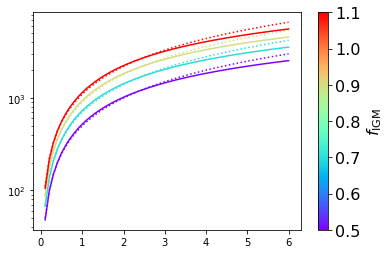

In [99]:

zs = np.linspace(0.1,6,60)
ps = np.arange(0.5,1.1,0.1)[::2]
f_IGM0s = np.arange( 0.3,1.0,0.1 )
for p, color in zip( ps, Rainbow(ps) ):
    DMs = [ DM(z, f_IGM=p) for z in zs ]
#    plt.plot(zs, DMs/(zs*1000*p), color=color)
    plt.plot(zs, DMs, color=color)
    plt.plot( zs, zs*1000*p, color=color, linestyle=":")
plt.yscale('log')
#plt.xlim(0,1)
Colorbar( ps, label=r"$f_{\rm IGM}$" )


Simulations show that at $z \gtrsim 1.5$ about 90 % of baryons were contained in the IGM (Meiskin 2008, 0711.3358). Here we check how much results for a linear evolution of $f_{\rm IGM}$ between redshifts $z=1.5$ and $z=0$ (solid) would differ from constant $f_{\rm IGM}$ (dotted). The right plot shows the ratio of the two graphs.

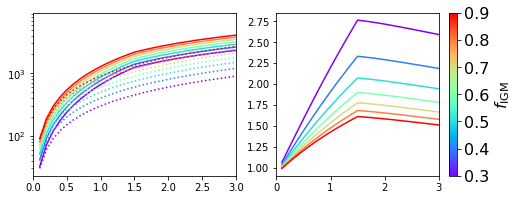

In [102]:

zs = np.linspace(0.1,6,60)
ps = np.arange(0.5,1.1,0.1)[::2]
p = 1
f_IGM0s = np.arange( 0.3,1.0,0.1 )

fig, axs = plt.subplots(1,2, figsize=(8,3))

for f_IGM0, color in zip( f_IGM0s, Rainbow(f_IGM0s) ):
    f_IGMs = f_IGM0 + np.where( zs<1.5, zs, 1.5)/1.5 * 0.50
    DMs = [ DM(z, f_IGM=f_IGM) for z, f_IGM in zip( zs, f_IGMs ) ]
    axs[1].plot(zs, DMs/(zs*1000*f_IGM0), color=color)
    axs[0].plot(zs, DMs, color=color)
    axs[0].plot( zs, zs*1000*f_IGM0, color=color, linestyle=":")
for ax in axs:
    ax.set_xlim(0,3)
axs[0].set_yscale('log')
Colorbar( f_IGM0s, label=r"$f_{\rm IGM}$" )


In [2]:
import DM_Hackstein

In [19]:
LoS = DM_Hackstein.Sightline( 1, 1e-3 )

0.0  %
16.666666666666668  %
33.333333333333336  %
50.0  %
66.66666666666667  %
83.33333333333333  %


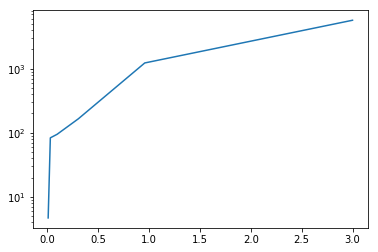

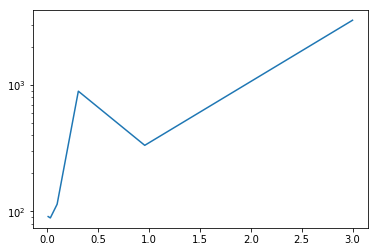

this took 346 seconds or 5.8 minutes


In [20]:

z, DM, RM = HowLong( LoS.MC_DM_RM, 1, 0.01, 3, 6 ) 

plt.plot(z,DM)
plt.yscale('log')
plt.show()
plt.plot(z,np.abs(RM))
plt.yscale('log')
plt.show()


this took 103 seconds or 1.7 minutes


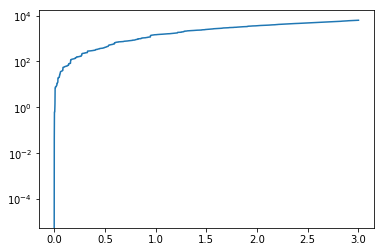

In [22]:


zs, dens = LoS.CreateArrays( 3.0 )
DMs = HowLong( LoS.DispersionMeasure, dens, zs )
plt.plot( zs, DMs)
plt.yscale('log')


In [57]:
z_max = 0.01
t0 = time()

def next(z):
    return z + JeansLength(z)

za = np.array([0])
z=0.
while z<z_max:
    z = next(za[-1])
    za = np.append(za,z)

#za = [ lambda z: z + JeansLength(z) while z < z_max ]

print(za)


t1 = time()

za = np.array([0])
z=0.
while z<z_max:
    z = za[-1] + JeansLength(za[-1])
    za = np.append(za,z)
print(za)
t2 = time()

print( "first was %f faster" % ( (t2-t1)/(t1-t0) )  )

[0.         0.0005199  0.00103979 0.00155967 0.00207953 0.00259939
 0.00311924 0.00363908 0.00415891 0.00467873 0.00519855 0.00571835
 0.00623815 0.00675794 0.00727772 0.00779749 0.00831726 0.00883702
 0.00935677 0.00987651 0.01039624]
[0.         0.0005199  0.00103979 0.00155967 0.00207953 0.00259939
 0.00311924 0.00363908 0.00415891 0.00467873 0.00519855 0.00571835
 0.00623815 0.00675794 0.00727772 0.00779749 0.00831726 0.00883702
 0.00935677 0.00987651 0.01039624]
first was 0.988528 faster


In [7]:
from astropy.cosmology import Planck15, z_at_value
import astropy.units as u
def JeansLength(z):
    """                                                                                                                     
    Computes Jeans length in unitless Delta z                                                                               
    lambda_J=2.3 Mpc (1+z)^-3/2 Pshirkov 2016                                                                               
    """
    dist=Planck15.lookback_distance(z).value # in Mpc                                                                       
    jeanslength=2.3*(1+z)**(-1.5)              # in Mpc                                                                     
    z1=z_at_value(Planck15.lookback_distance,(dist+jeanslength)*u.Mpc)
    return z1-z


In [72]:
N = 10
print( 100.*(2*N+1)/60 )

35.0


(2, 2)